## Setup and Data Loading

In [6]:
import polars as pl
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
pd.options.display.float_format = '{:,.2f}'.format

# Load Model and Test Data
MODEL_PATH = Path("../artifacts/models/xgb_v1.joblib")
DATA_PATH = Path("../data/processed/paysim_features_v1_1.parquet")
TEST_START_DAY = 26

print("Loading model and test data...")
bundle = joblib.load(MODEL_PATH)
model = bundle["model"]
feature_cols = bundle["features"]

df_test = pl.scan_parquet(DATA_PATH).filter(pl.col("day") >= TEST_START_DAY).collect()
X_test = df_test.select(feature_cols).to_numpy()
y_test = df_test.select("isFraud").to_numpy().ravel()
amounts = df_test.select("amount").to_numpy().ravel()

# Generate Probabilities
print("Scoring test transactions...")
y_probs = model.predict_proba(X_test)[:, 1]
print(f"Scored {len(y_probs):,} transactions.")

Loading model and test data...
Scoring test transactions...
Scored 89,698 transactions.


## Simulating Business Economics

In [7]:
# --- Business Assumptions ---
# 1. Margin: We make a 2% fee on good transactions.
# 2. Fraud Loss: We lose 100% of the transaction amount if fraud succeeds.
# 3. Operational Cost: It costs $5 in support/review time every time we block a transaction (False Positive).

MARGIN_RATE = 0.02
REVIEW_COST = 5.0

results = []
thresholds = np.linspace(0.01, 0.99, 99)

for thresh in thresholds:
    # Simulate blocking decisions
    preds = (y_probs >= thresh).astype(int)
    
    # Outcomes
    true_positives = (preds == 1) & (y_test == 1) # Fraud stopped
    false_positives = (preds == 1) & (y_test == 0) # Good user blocked (Insult)
    false_negatives = (preds == 0) & (y_test == 1) # Fraud missed
    true_negatives = (preds == 0) & (y_test == 0) # Good user approved
    
    # Financial Impact
    revenue_kept = np.sum(amounts[true_negatives]) * MARGIN_RATE
    fraud_losses = np.sum(amounts[false_negatives])
    fp_penalties = np.sum(false_positives) * REVIEW_COST
    
    net_profit = revenue_kept - fraud_losses - fp_penalties
    
    # Operational Metrics
    approval_rate = (np.sum(preds == 0) / len(y_test)) * 100
    recall = (np.sum(true_positives) / np.sum(y_test)) * 100 if np.sum(y_test) > 0 else 0
    precision = (np.sum(true_positives) / np.sum(preds)) * 100 if np.sum(preds) > 0 else 0
    
    results.append({
        "Threshold": thresh,
        "Net Profit ($)": net_profit,
        "Approval Rate (%)": approval_rate,
        "Fraud Caught (%)": recall,
        "Precision (%)": precision,
        "Good Users Blocked": np.sum(false_positives)
    })

df_results = pd.DataFrame(results)

# Find the threshold that maximizes profit
optimal_row = df_results.loc[df_results["Net Profit ($)"].idxmax()]
print("=== OPTIMAL BUSINESS THRESHOLD ===")
print(optimal_row)

=== OPTIMAL BUSINESS THRESHOLD ===
Threshold                      0.09
Net Profit ($)       131,053,571.49
Approval Rate (%)             89.79
Fraud Caught (%)              81.46
Precision (%)                 11.90
Good Users Blocked         8,070.00
Name: 8, dtype: float64


## Visualizing the Trade-off

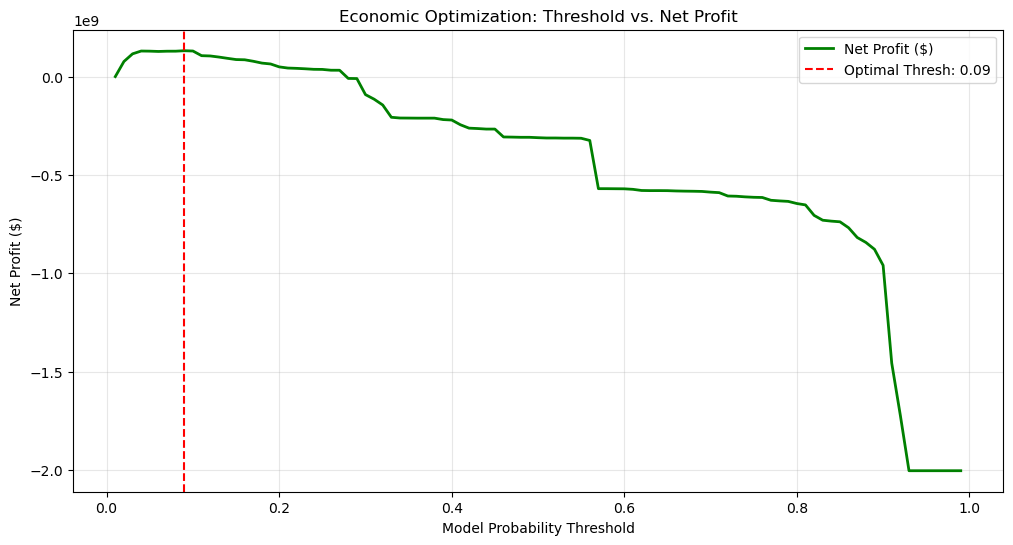

,Threshold,Net Profit ($),Approval Rate (%),Fraud Caught (%),Precision (%),Good Users Blocked
8,0.09,"131,053,571.49",89.79,81.46,11.90,8070
9,0.10,"129,535,005.51",91.46,79.07,13.80,6606
3,0.04,"129,495,431.03",85.20,87.52,8.82,12105
4,0.05,"128,847,964.56",85.81,86.47,9.09,11571
7,0.08,"128,698,785.60",88.66,82.66,10.87,9070


In [8]:
plt.figure(figsize=(12, 6))

# Plot Net Profit curve
plt.plot(df_results["Threshold"], df_results["Net Profit ($)"], label="Net Profit ($)", color="green", linewidth=2)

# Highlight the optimal point
plt.axvline(x=optimal_row["Threshold"], color='red', linestyle='--', label=f'Optimal Thresh: {optimal_row["Threshold"]:.2f}')

plt.title("Economic Optimization: Threshold vs. Net Profit")
plt.xlabel("Model Probability Threshold")
plt.ylabel("Net Profit ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show the top 5 most profitable thresholds
df_results.sort_values(by="Net Profit ($)", ascending=False).head(5)